# Regularization Analysis for LC Duration Prediction

This notebook implements regularized regression models with proper hyperparameter tuning using scikit-learn's cross-validation tools.

In [9]:
import sys
import os

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RepeatedStratifiedKFold, TimeSeriesSplit
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, RobustScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

import mlflow

# Get the absolute path to the project root directory
project_root = os.path.abspath(os.path.join(os.getcwd(), '../..'))
sys.path.append(project_root)

# Now import prepare_data
from src.python.preprocess import prepare_data

In [20]:
project_root

'/workspace'

In [11]:
df = pd.read_csv('../../data/LC_engineered.csv')

target = 'Duration_In_Min'
target_2 = 'Occupancy'
features_to_drop = ['Student_IDs', 'Semester', 'Class_Standing', 'Major', 'Expected_Graduation',
                    'Course_Name', 'Course_Number', 'Course_Type', 'Course_Code_by_Thousands',
                    'Check_Out_Time', 'Session_Length_Category', target, target_2]


In [12]:
X, y = prepare_data(df, target, features_to_drop)

In [13]:
# prepare_data()[0].shape
X.columns
X.head()

,Semester_Week,Term_Credit_Hours,Term_GPA,Total_Credit_Hours_Earned,Cumulative_GPA,Change_in_GPA,Is_Weekend,Check_In_Week,Check_In_Hour,Has_Multiple_Majors,...,Class_Standing_Self_Reported_Other,Class_Standing_Self_Reported_Second Year,Class_Standing_Self_Reported_Third Year,Class_Standing_BGSU_Freshman,Class_Standing_BGSU_Junior,Class_Standing_BGSU_Senior,Class_Standing_BGSU_Sophomore,Week_Volume_Low Volume,GPA_Trend_Category_Improving,GPA_Trend_Category_Stable
0,1,12,2.250,136.0,2.720,-0.470,False,4,10,True,...,False,False,False,False,False,False,False,True,False,False
1,1,16,2.312,131.0,2.562,-0.250,False,4,11,True,...,False,False,False,False,False,False,False,True,False,False
2,1,17,3.000,148.0,2.812,0.188,False,4,13,False,...,False,False,False,False,False,False,False,True,True,False
3,1,21,3.562,150.0,3.633,-0.071,False,4,14,False,...,False,False,False,False,False,False,False,True,False,False
4,1,15,3.000,119.0,3.105,-0.105,False,4,10,True,...,False,False,False,False,False,True,False,True,False,False


In [14]:
# Set MLflow tracking URI for the database
sqlite_uri = f"sqlite:///{project_root}/mlflow.db"
# mlflow.set_tracking_uri(sqlite_uri)
mlflow.set_tracking_uri("http://127.0.0.1:5000")

# Set MLflow experiment directory to project root
os.environ["MLFLOW_TRACKING_DIR"] = f"{project_root}/mlruns"

# Enable autologging
mlflow.sklearn.autolog()

In [15]:
# Define models and hyperparameters
models = {
    'Ridge': (Ridge(), {
        'model__alpha': np.logspace(-3, 3, 7)
    }),
    'Lasso': (Lasso(), {
        'model__alpha': np.logspace(-3, 3, 7)
    }),
    'ElasticNet': (ElasticNet(), {
        'model__alpha': np.logspace(-3, 3, 7),
        'model__l1_ratio': np.linspace(0.1, 0.9, 5)
    })
}

In [ ]:
# Cross-validation
class CustomTimeSeriesSplit:
    def __init__(self, n_splits=5, max_train_size=None):
        self.n_splits = n_splits
        self.max_train_size = max_train_size
        self.tscv = TimeSeriesSplit(n_splits=self.n_splits, max_train_size=self.max_train_size)

    def split(self, X, y=None, groups=None):
        for train_index, test_index in self.tscv.split(X):
            yield train_index, test_index

    def get_n_splits(self, X, y=None, groups=None):
        return self.n_splits

kfold_stratified_cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=3)
kfold_cv = KFold(n_splits=5, shuffle=True, random_state=3)  # Changed from RepeatedStratifiedKFold since this is regression
time_series_cv = CustomTimeSeriesSplit(n_splits=10)

In [17]:

mlflow.set_experiment('Regularization')

# Initialize results list
results = []

# Iterate over models
for name, (model, params) in models.items():
    mlflow.set_tag('model', name)
    print(f"\nTuning {name}...")
    
    pipelines = {
        'basic': Pipeline([
            ('model', model)
        ]),
        'standardized': Pipeline([
            ('scale', StandardScaler()),
            ('model', model)
        ]),
        'robust': Pipeline([
            ('scale', RobustScaler()),
            ('model', model)
        ]),
        # 'polynomial': Pipeline([
        #     ('poly', PolynomialFeatures(degree=2, include_bias=False)),
        #     ('scale', StandardScaler()),
        #     ('model', model)
        # ])
    }
    
    # Iterate over each pipeline
    for scale_type, pipeline in pipelines.items():
        # Grid Search
        search = GridSearchCV(
            pipeline, 
            params, 
            scoring='neg_mean_squared_error',
            cv=cv,
            n_jobs=-1,
            verbose=0
        )
        
        # Fit the model
        search.fit(X, y)
        
        # Calculate RMSE from negative MSE
        rmse_score = np.sqrt(-search.best_score_)
        
        # Store results
        results.append({
            'model': name,
            'scale': scale_type,
            'rmse': rmse_score,
            'best_params': search.best_params_
        })
        
        print(f"Best for {name} ({scale_type}): RMSE={rmse_score:.4f}, Params={search.best_params_}")

2024/11/24 12:33:48 INFO mlflow.tracking.fluent: Experiment with name 'Ridge' does not exist. Creating a new experiment.


2024/11/24 12:33:49 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/site-packages/mlflow/types/utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."



Tuning Ridge...
Fitting 5 folds for each of 7 candidates, totalling 35 fits


2024/11/24 12:33:50 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/site-packages/mlflow/types/utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2024/11/24 12:33:51 INFO mlflow.sklearn.utils: Logging the 5 best runs, 2 runs will be omitted.
2024/11/24 12:33:52 WARNING mlflow.utils.autologging_utils: MLflo

🏃 View run aged-stag-700 at: http://127.0.0.1:5000/#/experiments/257981163434387913/runs/6fa27b48b362407286775cfb953bc8ed
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/257981163434387913
🏃 View run learned-squid-846 at: http://127.0.0.1:5000/#/experiments/257981163434387913/runs/d9d8ace1ba2d48ad898e69d441316674
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/257981163434387913
🏃 View run secretive-stoat-662 at: http://127.0.0.1:5000/#/experiments/257981163434387913/runs/f5f82fd273d6466f95c96a2a65c0cfef
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/257981163434387913
🏃 View run secretive-owl-394 at: http://127.0.0.1:5000/#/experiments/257981163434387913/runs/b0c7fd8176df4206befaf87d5f9ee601
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/257981163434387913
🏃 View run awesome-croc-390 at: http://127.0.0.1:5000/#/experiments/257981163434387913/runs/97c776ed089e43c482055c9484ebf031
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2579811

2024/11/24 12:33:52 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/site-packages/mlflow/types/utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2024/11/24 12:33:54 INFO mlflow.sklearn.utils: Logging the 5 best runs, 2 runs will be omitted.


🏃 View run traveling-sponge-105 at: http://127.0.0.1:5000/#/experiments/257981163434387913/runs/5fab884d149b49759e632f2663514b04
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/257981163434387913
🏃 View run bittersweet-shad-10 at: http://127.0.0.1:5000/#/experiments/257981163434387913/runs/6e9c08febf2745d6a01c3c4247a46558
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/257981163434387913
🏃 View run stately-snake-396 at: http://127.0.0.1:5000/#/experiments/257981163434387913/runs/90c5960ea2534feebf0acbf8b8ee28cc
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/257981163434387913
🏃 View run amazing-ray-327 at: http://127.0.0.1:5000/#/experiments/257981163434387913/runs/2db221e5d9da4a2a897fd8a278013efc
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/257981163434387913
🏃 View run rogue-stoat-240 at: http://127.0.0.1:5000/#/experiments/257981163434387913/runs/f0db2c3c9491409592247a5bb4804cdc
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/257

2024/11/24 12:34:55 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 133fd6534bdf44908ff7d03a7777bd51. Failed operations: [MlflowException("API request to http://127.0.0.1:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'127.0.0.1\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-batch (Caused by ResponseError(\'too many 500 error responses\'))")]')]
2024/11/24 12:34:55 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/site-packages/mlflow/types/utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats an

Best for Ridge (standardized): RMSE=60.5945, Params={'model__alpha': np.float64(100.0)}
Fitting 5 folds for each of 7 candidates, totalling 35 fits


2024/11/24 12:34:56 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/site-packages/mlflow/types/utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2024/11/24 12:34:57 INFO mlflow.sklearn.utils: Logging the 5 best runs, 2 runs will be omitted.


🏃 View run illustrious-vole-337 at: http://127.0.0.1:5000/#/experiments/257981163434387913/runs/030aebffbc5e4e47aff9a3670a49cd96
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/257981163434387913
🏃 View run sassy-croc-161 at: http://127.0.0.1:5000/#/experiments/257981163434387913/runs/451ca358740c48078c6bceffba98b015
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/257981163434387913
🏃 View run thundering-chimp-756 at: http://127.0.0.1:5000/#/experiments/257981163434387913/runs/594c9212a8a54f9799d708d1de2ddabe
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/257981163434387913
🏃 View run brawny-jay-536 at: http://127.0.0.1:5000/#/experiments/257981163434387913/runs/3593aeb6b3b54d5c9918ec5973277313
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/257981163434387913
🏃 View run indecisive-hog-673 at: http://127.0.0.1:5000/#/experiments/257981163434387913/runs/4e26c92dd5464be0a0df23ca3e6bebc1
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/257

2024/11/24 12:35:58 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 133fd6534bdf44908ff7d03a7777bd51. Failed operations: [MlflowException("API request to http://127.0.0.1:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'127.0.0.1\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-batch (Caused by ResponseError(\'too many 500 error responses\'))")]')]
2024/11/24 12:35:58 INFO mlflow.tracking.fluent: Experiment with name 'Lasso' does not exist. Creating a new experiment.
2024/11/24 12:35:58 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/site-packages/mlflow/types/utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python canno

Best for Ridge (robust): RMSE=60.5680, Params={'model__alpha': np.float64(10.0)}

Tuning Lasso...
Fitting 5 folds for each of 7 candidates, totalling 35 fits


/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.658e+06, tolerance: 3.578e+03
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.252e+06, tolerance: 3.591e+03
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.360e+06, tolerance: 3.615e

🏃 View run omniscient-crab-924 at: http://127.0.0.1:5000/#/experiments/257981163434387913/runs/4e30934e66c042a199f9a429da6d8e03
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/257981163434387913
🏃 View run enthused-croc-595 at: http://127.0.0.1:5000/#/experiments/257981163434387913/runs/b9be266307d24ae292181e3dcce8f392
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/257981163434387913
🏃 View run suave-cow-401 at: http://127.0.0.1:5000/#/experiments/257981163434387913/runs/126e890462a94b0fa5d1968944fe957c
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/257981163434387913
🏃 View run nebulous-eel-873 at: http://127.0.0.1:5000/#/experiments/257981163434387913/runs/315b15cb2c1e495ab69c8545c640d93d
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/257981163434387913
🏃 View run gaudy-sloth-24 at: http://127.0.0.1:5000/#/experiments/257981163434387913/runs/0e962d215bb54155ace37b34887d4fca
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2579811634

2024/11/24 12:37:04 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 133fd6534bdf44908ff7d03a7777bd51. Failed operations: [MlflowException("API request to http://127.0.0.1:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'127.0.0.1\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-batch (Caused by ResponseError(\'too many 500 error responses\'))")]')]
2024/11/24 12:37:04 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/site-packages/mlflow/types/utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats an

Best for Lasso (basic): RMSE=60.5713, Params={'model__alpha': np.float64(0.01)}
Fitting 5 folds for each of 7 candidates, totalling 35 fits


/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.983e+06, tolerance: 3.615e+03
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.728e+06, tolerance: 3.578e+03
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.977e+04, tolerance: 3.591e

🏃 View run orderly-roo-739 at: http://127.0.0.1:5000/#/experiments/257981163434387913/runs/bae736708e8845fca5c3bc8ea4237451
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/257981163434387913
🏃 View run upset-shark-718 at: http://127.0.0.1:5000/#/experiments/257981163434387913/runs/0fa4c8c6e6df480a970f465dc6a0f6fe
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/257981163434387913
🏃 View run resilient-shrike-189 at: http://127.0.0.1:5000/#/experiments/257981163434387913/runs/fe05468581464c5c997c385b20db95e6
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/257981163434387913
🏃 View run languid-worm-933 at: http://127.0.0.1:5000/#/experiments/257981163434387913/runs/df9ab2a8ae494346b50e9f32b0ccd811
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/257981163434387913
🏃 View run thoughtful-mole-628 at: http://127.0.0.1:5000/#/experiments/257981163434387913/runs/58d661731ef84786bf5d82125129a9f1
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2579

2024/11/24 12:38:10 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 133fd6534bdf44908ff7d03a7777bd51. Failed operations: [MlflowException("API request to http://127.0.0.1:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'127.0.0.1\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-batch (Caused by ResponseError(\'too many 500 error responses\'))")]')]
2024/11/24 12:38:11 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/site-packages/mlflow/types/utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats an

Best for Lasso (standardized): RMSE=60.5981, Params={'model__alpha': np.float64(0.01)}
Fitting 5 folds for each of 7 candidates, totalling 35 fits


/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.013e+05, tolerance: 3.615e+03
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.991e+05, tolerance: 3.578e+03
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.517e+05, tolerance: 3.591e

🏃 View run burly-sheep-530 at: http://127.0.0.1:5000/#/experiments/257981163434387913/runs/a8642fe9b59e48b7a1556e0a183ac2f2
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/257981163434387913
🏃 View run dapper-steed-386 at: http://127.0.0.1:5000/#/experiments/257981163434387913/runs/d8856b4f8f5d412fb695e0aa4af3853a
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/257981163434387913
🏃 View run resilient-crow-558 at: http://127.0.0.1:5000/#/experiments/257981163434387913/runs/d546376640684b778457abdd08044342
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/257981163434387913
🏃 View run dazzling-ram-490 at: http://127.0.0.1:5000/#/experiments/257981163434387913/runs/2785d7c59869429eb59d13a0333853da
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/257981163434387913
🏃 View run skittish-bird-831 at: http://127.0.0.1:5000/#/experiments/257981163434387913/runs/20835efb17544fdaaf4281682fef88b3
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2579811

2024/11/24 12:39:16 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 133fd6534bdf44908ff7d03a7777bd51. Failed operations: [MlflowException("API request to http://127.0.0.1:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'127.0.0.1\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-batch (Caused by ResponseError(\'too many 500 error responses\'))")]')]
2024/11/24 12:39:16 INFO mlflow.tracking.fluent: Experiment with name 'ElasticNet' does not exist. Creating a new experiment.


Best for Lasso (robust): RMSE=60.5722, Params={'model__alpha': np.float64(0.01)}

Tuning ElasticNet...


2024/11/24 12:39:16 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/site-packages/mlflow/types/utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."


Fitting 5 folds for each of 35 candidates, totalling 175 fits


/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.439e+05, tolerance: 3.578e+03
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.376e+05, tolerance: 3.635e+03
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.036e+05, tolerance: 3.635e

🏃 View run adventurous-owl-800 at: http://127.0.0.1:5000/#/experiments/257981163434387913/runs/85e41e687cf743a69e8943ac084c04b6
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/257981163434387913
🏃 View run learned-quail-548 at: http://127.0.0.1:5000/#/experiments/257981163434387913/runs/30f094a6d1b54e92801ddbe51890732d
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/257981163434387913
🏃 View run resilient-colt-429 at: http://127.0.0.1:5000/#/experiments/257981163434387913/runs/0500b981ec2e488a8f83fa4450aa6634
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/257981163434387913
🏃 View run smiling-stag-541 at: http://127.0.0.1:5000/#/experiments/257981163434387913/runs/31f0358c6df04a02a685ab59f0925c20
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/257981163434387913
🏃 View run industrious-koi-475 at: http://127.0.0.1:5000/#/experiments/257981163434387913/runs/ee20c4fcba794c8ca9a431e3468007f0
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/

2024/11/24 12:40:27 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 133fd6534bdf44908ff7d03a7777bd51. Failed operations: [MlflowException("API request to http://127.0.0.1:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'127.0.0.1\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-batch (Caused by ResponseError(\'too many 500 error responses\'))")]')]
2024/11/24 12:40:28 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/site-packages/mlflow/types/utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats an

Best for ElasticNet (basic): RMSE=60.5663, Params={'model__alpha': np.float64(0.01), 'model__l1_ratio': np.float64(0.9)}
Fitting 5 folds for each of 35 candidates, totalling 175 fits


/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.474e+06, tolerance: 3.635e+03
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.527e+06, tolerance: 3.635e+03
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.760e+06, tolerance: 3.578e

🏃 View run indecisive-chimp-818 at: http://127.0.0.1:5000/#/experiments/257981163434387913/runs/37fad392afeb41e69df077b3930356c3
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/257981163434387913
🏃 View run overjoyed-moth-852 at: http://127.0.0.1:5000/#/experiments/257981163434387913/runs/2fd922be14534100a75939d77720ce27
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/257981163434387913
🏃 View run adorable-mole-338 at: http://127.0.0.1:5000/#/experiments/257981163434387913/runs/015914c39afd4d5fb757c5b760e830e9
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/257981163434387913
🏃 View run clean-asp-209 at: http://127.0.0.1:5000/#/experiments/257981163434387913/runs/2f7972971e7d4691ab93b1f2b7f5e015
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/257981163434387913
🏃 View run exultant-tern-745 at: http://127.0.0.1:5000/#/experiments/257981163434387913/runs/fae82bb63c334c9ab2ac69dee87fb806
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2579

2024/11/24 12:41:36 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 133fd6534bdf44908ff7d03a7777bd51. Failed operations: [MlflowException("API request to http://127.0.0.1:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'127.0.0.1\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-batch (Caused by ResponseError(\'too many 500 error responses\'))")]')]


Best for ElasticNet (standardized): RMSE=60.5943, Params={'model__alpha': np.float64(0.01), 'model__l1_ratio': np.float64(0.30000000000000004)}


2024/11/24 12:41:36 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/site-packages/mlflow/types/utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."


Fitting 5 folds for each of 35 candidates, totalling 175 fits


/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.606e+06, tolerance: 3.635e+03
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.071e+06, tolerance: 3.591e+03
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.315e+05, tolerance: 3.635e

🏃 View run burly-shad-214 at: http://127.0.0.1:5000/#/experiments/257981163434387913/runs/3ac01e929f28402b9358535fcc43c3a5
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/257981163434387913
🏃 View run fortunate-koi-32 at: http://127.0.0.1:5000/#/experiments/257981163434387913/runs/efd185e189b54731843aab83ec4e62ea
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/257981163434387913
🏃 View run exultant-shrew-805 at: http://127.0.0.1:5000/#/experiments/257981163434387913/runs/de4cba8774dd40dcb3f86b196ea3db90
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/257981163434387913
🏃 View run inquisitive-steed-69 at: http://127.0.0.1:5000/#/experiments/257981163434387913/runs/3a8c5ef823c549e487aadd6fd1213169
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/257981163434387913
🏃 View run receptive-fly-721 at: http://127.0.0.1:5000/#/experiments/257981163434387913/runs/7937153588df456389c3f07a1d75b8af
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2579

2024/11/24 12:42:45 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 133fd6534bdf44908ff7d03a7777bd51. Failed operations: [MlflowException("API request to http://127.0.0.1:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'127.0.0.1\', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-batch (Caused by ResponseError(\'too many 500 error responses\'))")]')]


Best for ElasticNet (robust): RMSE=60.5669, Params={'model__alpha': np.float64(0.01), 'model__l1_ratio': np.float64(0.9)}


In [18]:
# Convert results to DataFrame for easier analysis
results_df = pd.DataFrame(results)
print("\nAll Results:")
print(results_df.sort_values('rmse'))


All Results:
        model         scale       rmse  \
6  ElasticNet         basic  60.566285   
8  ElasticNet        robust  60.566942   
2       Ridge        robust  60.568049   
0       Ridge         basic  60.568556   
3       Lasso         basic  60.571330   
5       Lasso        robust  60.572232   
7  ElasticNet  standardized  60.594294   
1       Ridge  standardized  60.594498   
4       Lasso  standardized  60.598106   

                                         best_params  
6     {'model__alpha': 0.01, 'model__l1_ratio': 0.9}  
8     {'model__alpha': 0.01, 'model__l1_ratio': 0.9}  
2                             {'model__alpha': 10.0}  
0                             {'model__alpha': 10.0}  
3                             {'model__alpha': 0.01}  
5                             {'model__alpha': 0.01}  
7  {'model__alpha': 0.01, 'model__l1_ratio': 0.30...  
1                            {'model__alpha': 100.0}  
4                             {'model__alpha': 0.01}  


In [6]:
def tune_models():
    # Load data
    X, y = prepare_data()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)
    
    # Define models and their parameter grids
    models = {
        'Ridge': (Ridge(), {
            'alpha': np.logspace(-3, 3, 7)
        }),
        'Lasso': (Lasso(), {
            'alpha': np.logspace(-3, 3, 7)
        }),
        'ElasticNet': (ElasticNet(), {
            'alpha': np.logspace(-3, 3, 7),
            'l1_ratio': np.linspace(0.1, 0.9, 5)
        })
    }
    
    # Perform GridSearchCV for each model
    best_models = {}
    cv = KFold(n_splits=5, shuffle=True, random_state=3)
    
    for name, (model, param_grid) in models.items():
        print(f"\nTuning {name}...")
        grid_search = GridSearchCV(
            model, param_grid, cv=cv, 
            scoring='neg_mean_squared_error',
            n_jobs=-1
        )
        grid_search.fit(X_train, y_train)
        
        print(f"Best parameters: {grid_search.best_params_}")
        print(f"Best CV score: {np.sqrt(-grid_search.best_score_):.2f} (RMSE)")
        
        best_models[name] = grid_search.best_estimator_
    
    return best_models, X_train, X_test, y_train, y_test

In [7]:
def plot_feature_importance(model, feature_names, title):
    importance = np.abs(model.coef_)
    feat_importance = pd.DataFrame({
        'feature': feature_names,
        'importance': importance
    }).sort_values('importance', ascending=False)
    
    plt.figure(figsize=(12, 6))
    sns.barplot(data=feat_importance.head(10), x='importance', y='feature')
    plt.title(f'Top 10 Feature Importance - {title}')
    plt.tight_layout()
    plt.show()


Tuning Ridge...
Best parameters: {'alpha': np.float64(100.0)}
Best CV score: 61.03 (RMSE)

Tuning Lasso...


/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.177e+06, tolerance: 2.781e+03
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.682e+06, tolerance: 3.013e+03
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.723e+06, tolerance: 2.828e

Best parameters: {'alpha': np.float64(0.01)}
Best CV score: 61.04 (RMSE)

Tuning ElasticNet...


/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.371e+06, tolerance: 2.828e+03
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.659e+06, tolerance: 3.013e+03
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.332e+06, tolerance: 2.781e

Best parameters: {'alpha': np.float64(0.01), 'l1_ratio': np.float64(0.1)}
Best CV score: 61.03 (RMSE)

Ridge Performance Metrics:
RMSE: 59.4810
R2 Score: 0.0544

Lasso Performance Metrics:
RMSE: 59.4796
R2 Score: 0.0544

ElasticNet Performance Metrics:
RMSE: 59.4813
R2 Score: 0.0544


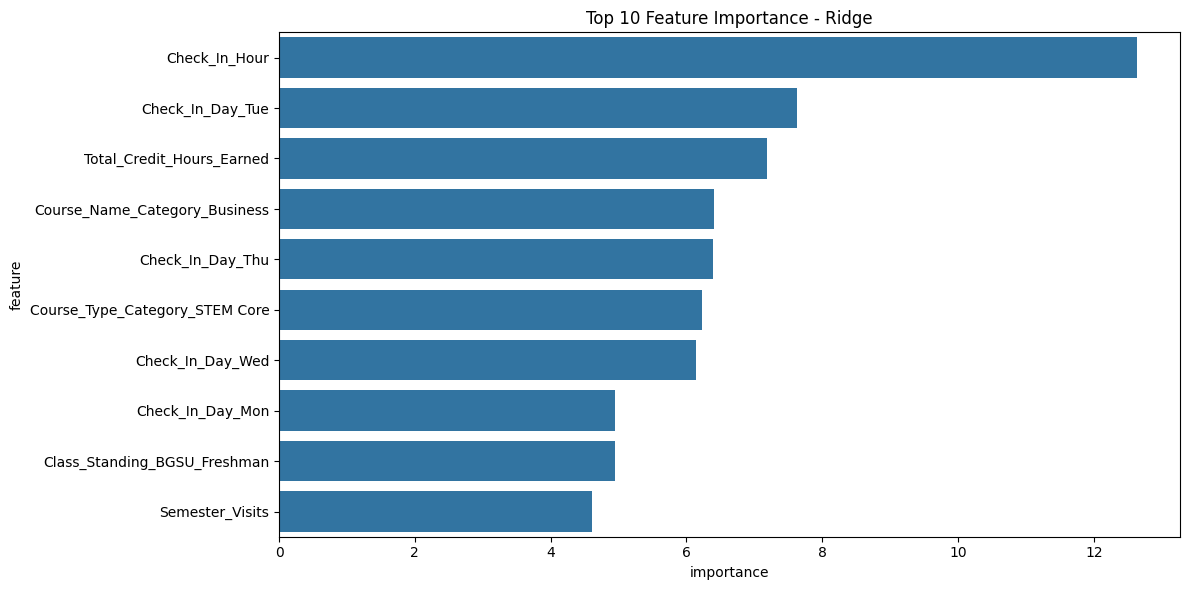

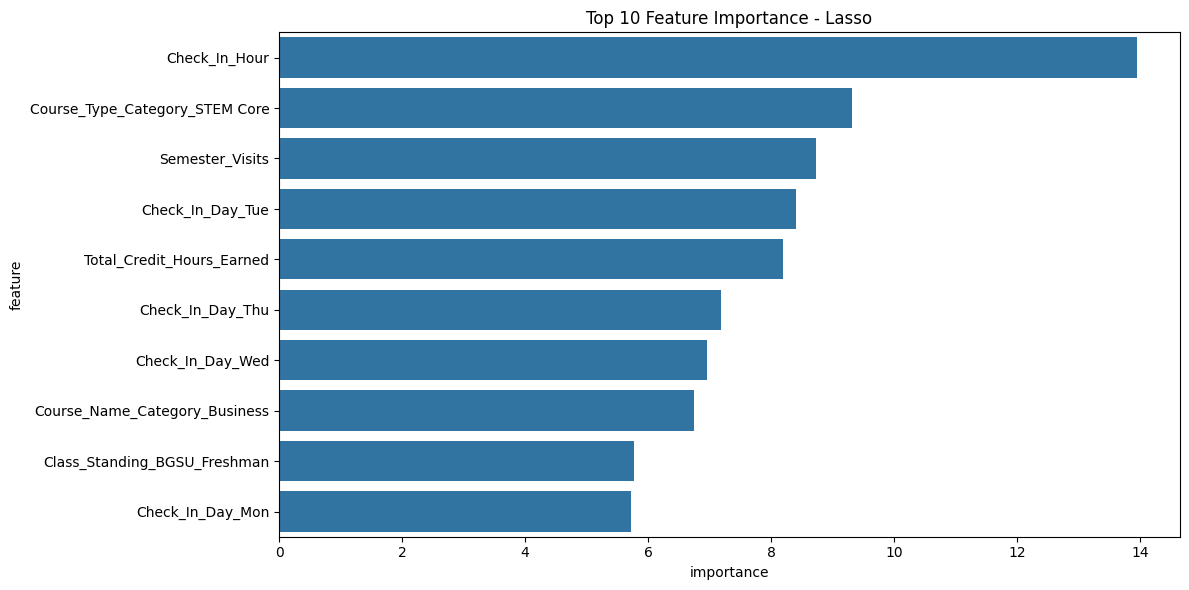

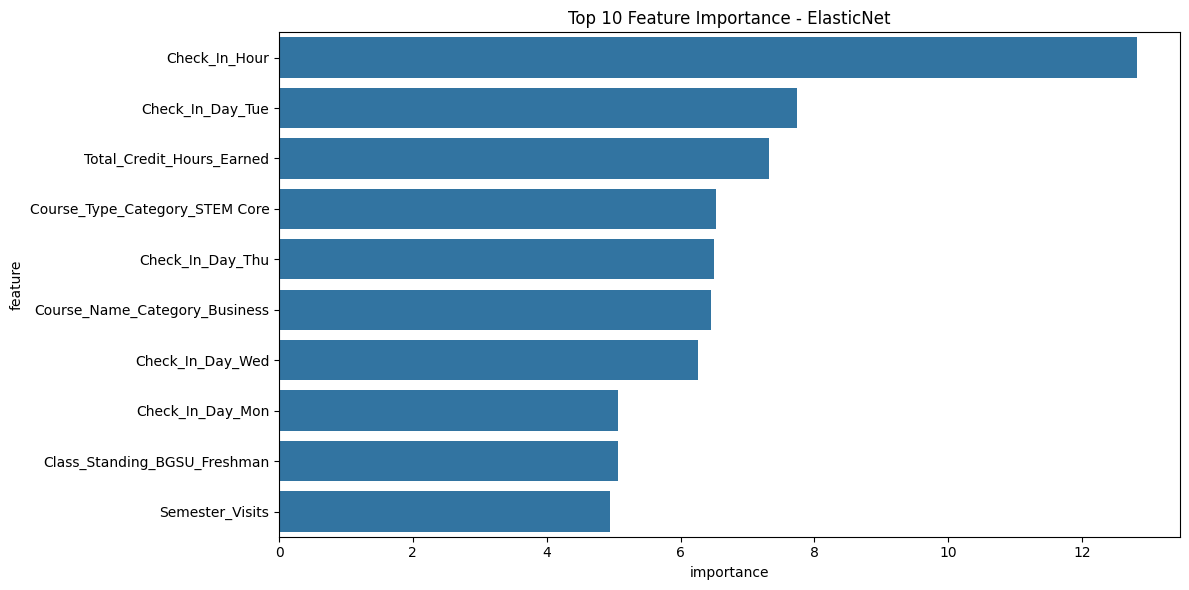

NameError: name 'plot_predictions' is not defined

In [8]:
# Run the analysis
best_models, X_train, X_test, y_train, y_test = tune_models()

# Get predictions
predictions = {name: model.predict(X_test) for name, model in best_models.items()}

# Print metrics
for name, y_pred in predictions.items():
    print(f"\n{name} Performance Metrics:")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.4f}")
    print(f"R2 Score: {r2_score(y_test, y_pred):.4f}")

# Plot feature importance for each model
for name, model in best_models.items():
    plot_feature_importance(model, X_train.columns, name)

# Plot predictions
plot_predictions(y_test, predictions.values(), predictions.keys())